# Setup

In [1]:
# import your standard packages
%run ../../../global_tools/start.py

# import your local functions
sys.path.insert(1, '../')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Parameters and Paths

In [2]:
inpath = "/tigress/GEOCLIM/LRGROUP/shared_data/dipole_mode_index/"

outfn = '../../data/dmi_processed.nc'


In [3]:
# get data from 1958-1999

dmi_ds_1958_1999 = pd.read_csv(inpath + 'dmi_03_01_1958_to_10_01_1999.csv')
dmi_ds_1958_1999 = dmi_ds_1958_1999.to_xarray()

# convert year and month to date time
x = []
for ii in range(len(dmi_ds_1958_1999.year)):
    x.append(dt.date(dmi_ds_1958_1999.year[ii],dmi_ds_1958_1999.month[ii],1))

dmi_ds_1958_1999['dmi'] = xr.DataArray(dmi_ds_1958_1999.dmi,dims = ['time'],coords =[pd.to_datetime(x)])
dmi_ds_1958_1999

<xarray.Dataset>
Dimensions:  (index: 500, time: 500)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time     (time) datetime64[ns] 1958-03-01 1958-04-01 ... 1999-10-01
Data variables:
    year     (index) int64 1958 1958 1958 1958 1958 ... 1999 1999 1999 1999 1999
    month    (index) int64 3 4 5 6 7 8 9 10 11 12 1 ... 12 1 2 3 4 5 6 7 8 9 10
    dmi      (time) float64 -0.1807 -0.4911 -0.9176 -1.16 ... 1.401 1.567 1.342

In [4]:
# get data from 1981-2020
dmi_ds_1981_2020 = xr.open_dataset(inpath + 'dmi_NOAA_11_04_1981_to_09_23_2020.nc')

# take monthly average and make new variable
dmi = dmi_ds_1981_2020.DMI.resample(WEDCEN2 = '1MS').mean(dim = 'WEDCEN2')
dmi_ds_1981_2020['dmi'] = xr.DataArray(dmi,dims = ['time'],coords =[dmi.WEDCEN2])
dmi_ds_1981_2020

<xarray.Dataset>
Dimensions:  (WEDCEN2: 2030, time: 467)
Coordinates:
  * WEDCEN2  (WEDCEN2) datetime64[ns] 1981-11-04 1981-11-11 ... 2020-09-23
  * time     (time) datetime64[ns] 1981-11-01 1981-12-01 ... 2020-09-01
Data variables:
    DMI      (WEDCEN2) float64 ...
    dmi      (time) float64 -0.2765 -0.2063 0.1823 ... 0.2018 -0.4285 -0.2623
Attributes:
    history:      FERRET V7.3 (optimized)  7-Oct-20
    Conventions:  CF-1.6

This paper: https://link.springer.com/article/10.1007/s00382-016-3382-2

Positive IOD = 5 month running average surpasses 0.5C ( 1 sd ) for more than four consecutive months
Negative IOD same but smaller than -0.5C

In [5]:
# normalize to same standard deviation of newer dataset
std_ratio = dmi_ds_1981_2020.dmi.std()/dmi_ds_1958_1999.dmi.std()
dmi_ds_1958_1999['dmi'] = dmi_ds_1958_1999.dmi * std_ratio

/home/jennap/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'DMI')

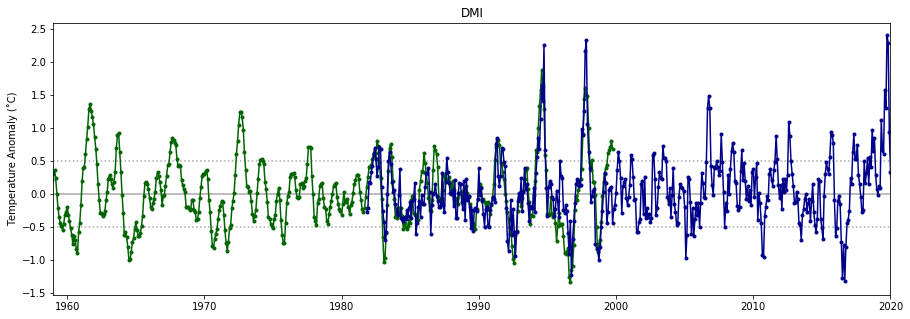

In [6]:
# plot before combinging into one
fig = plt.figure(figsize=(15, 5))
plt.axhline(y=0, color='darkgray', linestyle='-')
plt.axhline(y=0.5, color='darkgray', linestyle=':')
plt.axhline(y=-0.5, color='darkgray', linestyle=':')
old = plt.plot(dmi_ds_1958_1999.time,dmi_ds_1958_1999.dmi, marker = '.',color='darkgreen', label="Positive IOD")
new = plt.plot(dmi_ds_1981_2020.dmi.time,dmi_ds_1981_2020.dmi, marker = '.', color='darkblue',label = 'Negative IOD')
plt.xlim(dt.date(1959,1,1),dt.date(2020,1,1))
plt.ylabel('Temperature Anomaly (˚C)')
plt.title('DMI')

Text(0.5, 1.0, 'DMI')

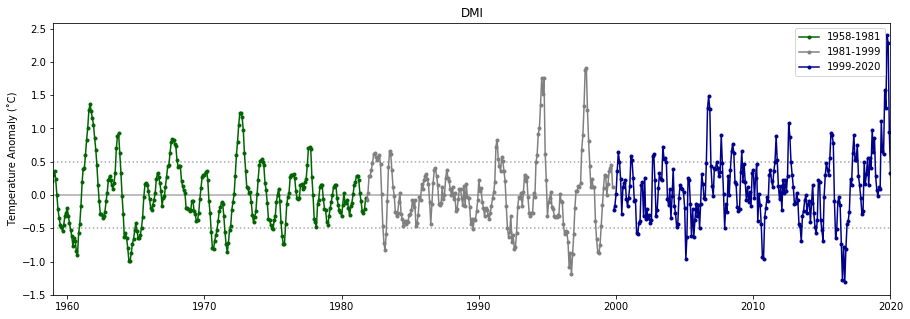

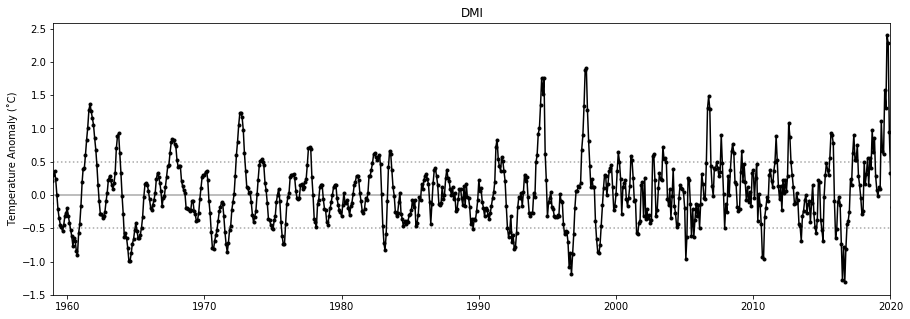

In [7]:
# take average of the two datasets when there is overlap
early = dmi_ds_1958_1999.dmi[dmi_ds_1958_1999.time < dmi_ds_1981_2020.time.min()]
middle = 0.5 *(dmi_ds_1958_1999.dmi[dmi_ds_1958_1999.time >= dmi_ds_1981_2020.time.min()] + 
             dmi_ds_1981_2020.dmi[dmi_ds_1981_2020.time <= dmi_ds_1958_1999.time.max()])
late = dmi_ds_1981_2020.dmi[dmi_ds_1981_2020.time > dmi_ds_1958_1999.time.max()]


# combine
dmi_total = np.concatenate([early, middle, late])
time_total = np.concatenate([early.time, middle.time, late.time])

# add to datset

dmi_ds = xr.Dataset(coords={'time': time_total})
dmi_ds['dmi'] = xr.DataArray(dmi_total,dims = ['time'],coords =[time_total])


# plot before combinging into one
fig = plt.figure(figsize=(15, 5))
plt.axhline(y=0, color='darkgray', linestyle='-')
plt.axhline(y=dmi_ds.dmi.std(), color='darkgray', linestyle=':')
plt.axhline(y=-dmi_ds.dmi.std(), color='darkgray', linestyle=':')
e = plt.plot(early.time,early, marker = '.',color='darkgreen', label="1958-1981")
m = plt.plot(middle.time,middle, marker = '.', color='gray',label = '1981-1999')
l = plt.plot(late.time,late, marker = '.', color='darkblue',label = '1999-2020')
plt.xlim(dt.date(1959,1,1),dt.date(2020,1,1))
plt.ylabel('Temperature Anomaly (˚C)')
plt.title('DMI')
plt.legend()

# plot before combinging into one
fig = plt.figure(figsize=(15, 5))
plt.axhline(y=0, color='darkgray', linestyle='-')
plt.axhline(y=dmi_ds.dmi.std(), color='darkgray', linestyle=':')
plt.axhline(y=-dmi_ds.dmi.std(), color='darkgray', linestyle=':')
plt.plot(dmi_ds.time,dmi_ds.dmi, marker = '.',color='k')
plt.xlim(dt.date(1959,1,1),dt.date(2020,1,1))
plt.ylabel('Temperature Anomaly (˚C)')
plt.title('DMI')

Text(0.5, 1.0, '3 Month Running Mean of DMI')

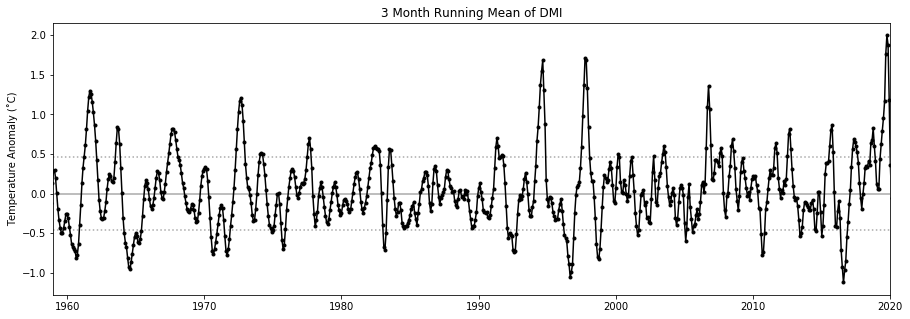

In [8]:
# find running mean
dmi_ds['dmi_3mo_runmean'] = dmi_ds.dmi.rolling(time=3, center=True).mean()

# plot before combinging into one
fig = plt.figure(figsize=(15, 5))
plt.axhline(y=0, color='darkgray', linestyle='-')
plt.axhline(y=dmi_ds.dmi_3mo_runmean.std(), color='darkgray', linestyle=':')
plt.axhline(y=-dmi_ds.dmi_3mo_runmean.std(), color='darkgray', linestyle=':')
plt.plot(dmi_ds.time,dmi_ds.dmi_3mo_runmean, marker = '.',color='k')
plt.xlim(dt.date(1959,1,1),dt.date(2020,1,1))
plt.ylabel('Temperature Anomaly (˚C)')
plt.title('3 Month Running Mean of DMI')

In [14]:
# get std
st_dev = np.array(dmi_ds.dmi_3mo_runmean.std())


# find pos iod years when > 1 std for mean SON and
# neg iod years when < -1 std for mean SON
pos_IOD_years = []
neg_IOD_years = []
neu_IOD_years = []

spos_IOD_years = []
sneg_IOD_years = []

wpos_IOD_years = []
wneg_IOD_years = []

for yy,year in enumerate(np.unique(dmi_ds.time.dt.year)):
  
    start_time = str(year) + '-09-01'
    end_time = str(year) + '-11-30'
    time_slice = slice(start_time, end_time)
    data = dmi_ds.dmi_3mo_runmean.sel(time=time_slice)
    
    if np.nanmean(data) >= st_dev:
        if np.nanmean(data) >= 2*st_dev:
            spos_IOD_years.append(year)
        else:
            wpos_IOD_years.append(year)
        if np.nanmean(data) >= st_dev:
            pos_IOD_years.append(year)
    elif np.nanmean(data) <= -st_dev:
        if np.nanmean(data) <= -1.5*st_dev:
            sneg_IOD_years.append(year)
        else:
            wneg_IOD_years.append(year)
        if np.nanmean(data) <= -st_dev:
            neg_IOD_years.append(year)  
    else:
        neu_IOD_years.append(year)

#     ind = dmi_ds.time.dt.year == year
#     data = dmi_ds.dmi[ind]

#     ind_data = np.zeros(data.shape)
    
#     # find data < std
#     ind_data[data > st_dev] = 1
    
#     # dinf data > std
#     ind_data[data < -st_dev] = -1
    
#     # find if there are 4 consecutive months (cutoff + 1)
#     cutoff = 3
#     neu = True
#     for mm in range(len(ind_data)-3):
# #         print(ind_data[mm],ind_data[mm+1],ind_data[mm+2])
        
#         # pos iod
#         if (ind_data[mm] == 1) & (ind_data[mm] == ind_data[mm+1]) & (ind_data[mm+1] == ind_data[mm+2]) & (ind_data[mm+2] == ind_data[mm+3]): 
#             neu = False
#             pos_IOD_years.append(year)
#         # neg iod
#         elif (ind_data[mm] == -1) & (ind_data[mm] == ind_data[mm+1]) & (ind_data[mm+1] == ind_data[mm+2]) & (ind_data[mm+2] == ind_data[mm+3]): 
#             neu = False
#             neg_IOD_years.append(year)

#     if neu == True:
#         neu_IOD_years.append(year)
            
    
dmi_ds['pos_IOD_years'] = xr.DataArray(np.unique(pos_IOD_years),dims = ['posyears'],coords =[np.unique(pos_IOD_years)])
dmi_ds['neg_IOD_years'] = xr.DataArray(np.unique(neg_IOD_years),dims = ['negyears'],coords =[np.unique(neg_IOD_years)])
dmi_ds['neu_IOD_years'] = xr.DataArray(np.unique(neu_IOD_years),dims = ['neuyears'],coords =[np.unique(neu_IOD_years)])


dmi_ds['spos_IOD_years'] = xr.DataArray(np.unique(spos_IOD_years),dims = ['sposyears'],coords =[np.unique(spos_IOD_years)])
dmi_ds['sneg_IOD_years'] = xr.DataArray(np.unique(sneg_IOD_years),dims = ['snegyears'],coords =[np.unique(sneg_IOD_years)])

dmi_ds['wpos_IOD_years'] = xr.DataArray(np.unique(wpos_IOD_years),dims = ['wposyears'],coords =[np.unique(wpos_IOD_years)])
dmi_ds['wneg_IOD_years'] = xr.DataArray(np.unique(wneg_IOD_years),dims = ['wnegyears'],coords =[np.unique(wneg_IOD_years)])

dmi_ds['std'] = xr.DataArray(st_dev)



/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice


In [15]:
time_slice = slice('1958-06-01', '2020-05-31')
dmi_ds = dmi_ds.sel(time = time_slice)
dmi_ds 

<xarray.Dataset>
Dimensions:          (negyears: 10, neuyears: 40, posyears: 13, snegyears: 6, sposyears: 6, time: 744, wnegyears: 4, wposyears: 7)
Coordinates:
  * time             (time) datetime64[ns] 1958-06-01 1958-07-01 ... 2020-05-01
  * posyears         (posyears) int64 1961 1963 1967 1972 ... 2015 2018 2019
  * negyears         (negyears) int64 1960 1964 1970 1971 ... 1998 2010 2016
  * neuyears         (neuyears) int64 1958 1959 1962 1965 ... 2014 2017 2020
  * sposyears        (sposyears) int64 1961 1972 1994 1997 2006 2019
  * snegyears        (snegyears) int64 1960 1964 1970 1996 1998 2016
  * wposyears        (wposyears) int64 1963 1967 1977 1982 2012 2015 2018
  * wnegyears        (wnegyears) int64 1971 1975 1992 2010
Data variables:
    dmi              (time) float64 -0.5891 -0.7216 -0.8133 ... 0.1378 0.5336
    dmi_3mo_runmean  (time) float64 -0.5922 -0.708 -0.7451 ... 0.1215 0.4255
    pos_IOD_years    (posyears) int64 1961 1963 1967 1972 ... 2015 2018 2019
    neg_I

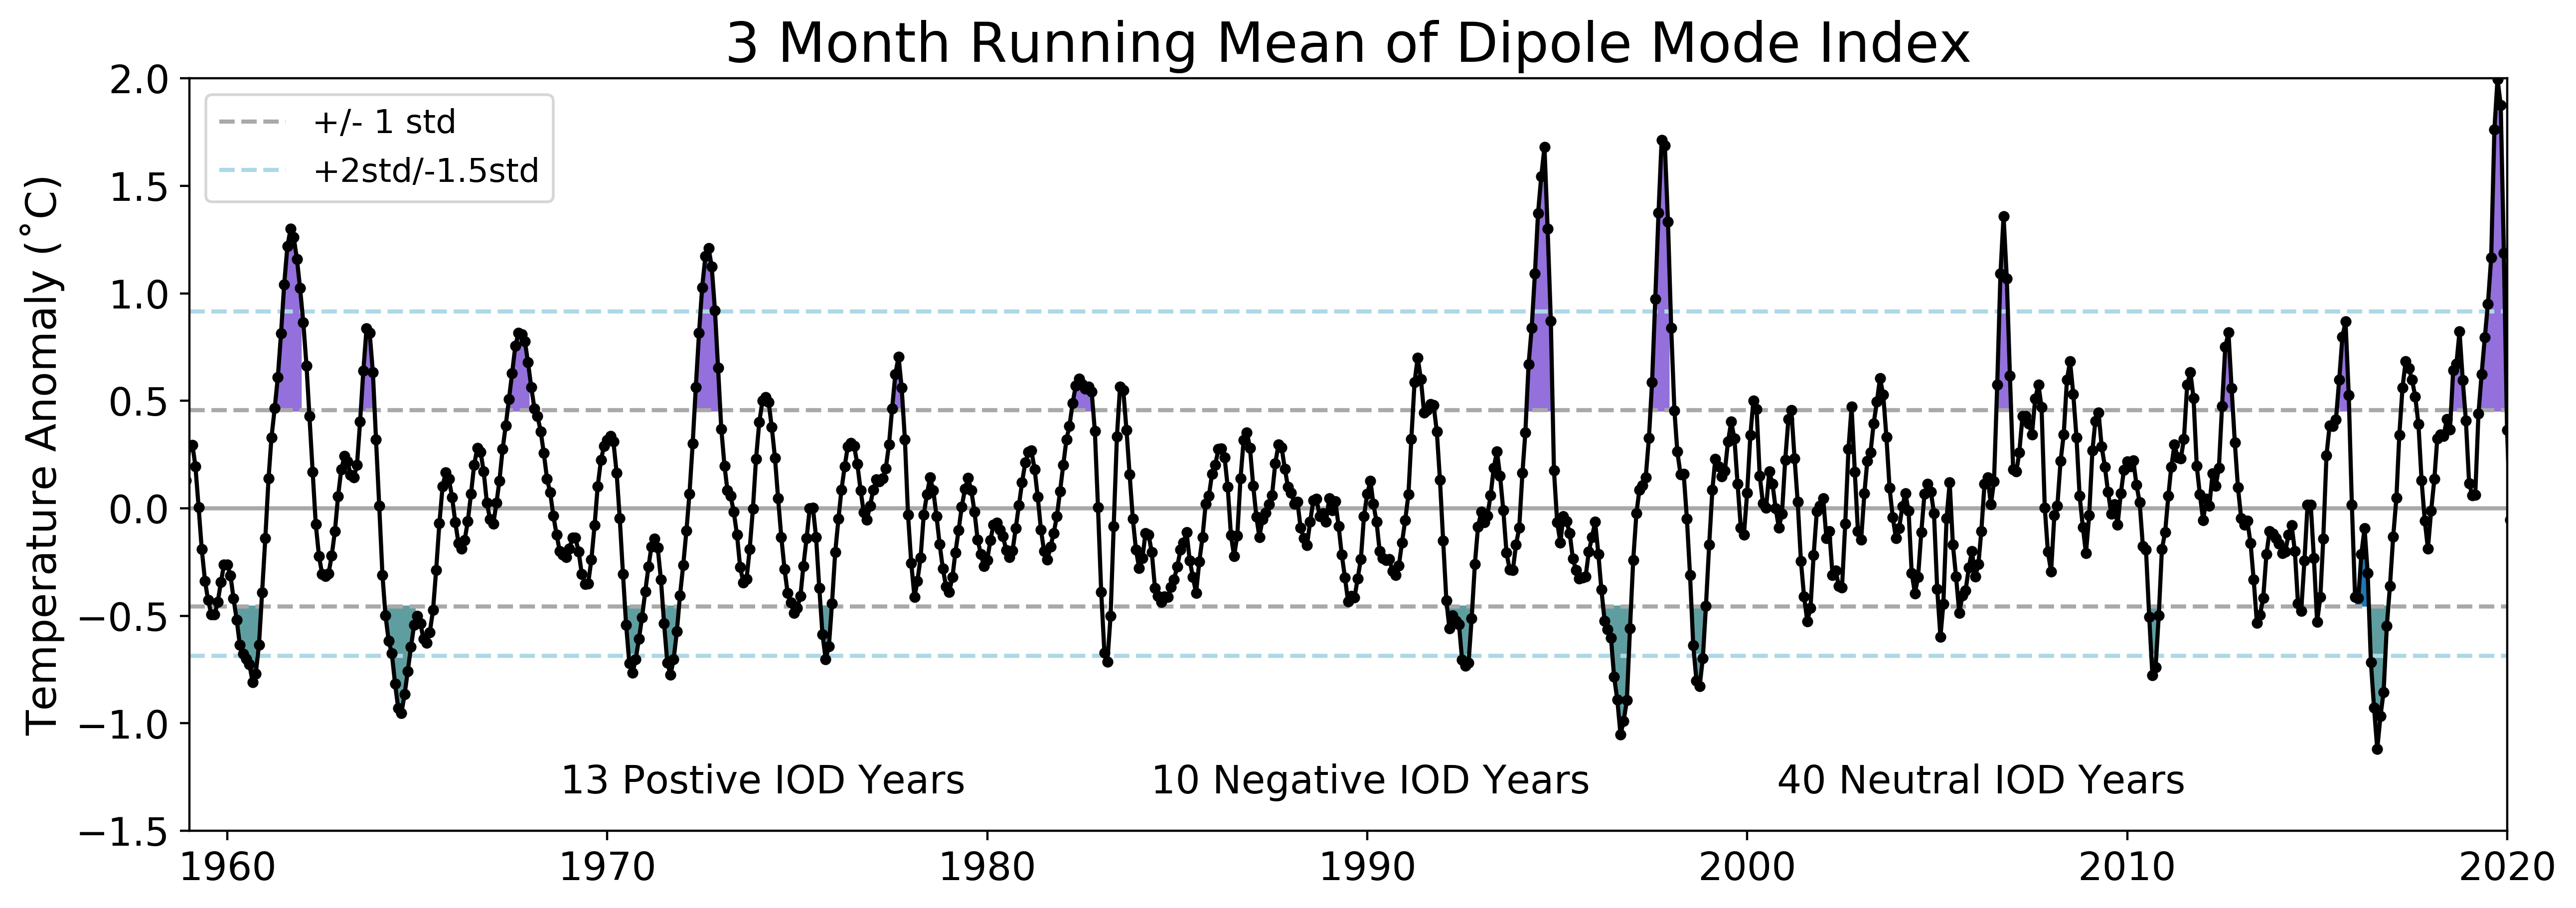

In [16]:
# plot before combinging into one

params = {'legend.fontsize': 12,
         'axes.labelsize': 15,
         'axes.titlesize': 20,
         'xtick.labelsize':14,
         'ytick.labelsize':14}

pylab.rcParams.update(params)

fig = plt.figure(figsize=(15, 5), dpi = 400)
plt.axhline(y=0, color='darkgray', linestyle='-')
std1 = plt.axhline(y=dmi_ds.dmi_3mo_runmean.std(), color='darkgray', linestyle='--')
plt.axhline(y=-dmi_ds.dmi_3mo_runmean.std(), color='darkgray', linestyle='--')
std2 = plt.axhline(y=dmi_ds.dmi_3mo_runmean.std()*2, color='lightblue', linestyle='--')
plt.axhline(y=-dmi_ds.dmi_3mo_runmean.std()*1.5, color='lightblue', linestyle='--')
plt.plot(dmi_ds.time,dmi_ds.dmi_3mo_runmean, marker = '.',color='k')
for posyear in pos_IOD_years:
    
    ind = dmi_ds.time.dt.year == posyear
    x = np.array(dmi_ds.time[ind])
    y2 = st_dev
    y1 = np.array(dmi_ds.dmi_3mo_runmean[ind])
    
    plt.fill_between(x,y1,y2,where=y1 > y2,color = 'mediumpurple')
    
for negyear in neg_IOD_years:
    
    ind = dmi_ds.time.dt.year == negyear
    x = np.array(dmi_ds.time[ind])
    y1 = -st_dev
    y2 = np.array(dmi_ds.dmi_3mo_runmean[ind])
    
    plt.fill_between(x,y1,y2,where=y1 > y2,color = 'cadetblue')
add_text(plt.gca(), str(len(dmi_ds.posyears)) + ' Postive IOD Years', x = 0.16,y=0.05, fontsize = 14)
add_text(plt.gca(), str(len(dmi_ds.negyears)) + ' Negative IOD Years', x = 0.415,y=0.05, fontsize = 14)
add_text(plt.gca(), str(len(dmi_ds.neuyears)) + ' Neutral IOD Years', x = 0.685,y=0.05, fontsize = 14)
plt.xlim(dt.date(1959,1,1),dt.date(2020,1,1))
plt.ylim([-1.5,2])
plt.ylabel('Temperature Anomaly (˚C)')
plt.title('3 Month Running Mean of Dipole Mode Index')

l = plt.legend([std1,std2],['+/- 1 std', '+2std/-1.5std'],facecolor = 'w', loc = 'upper left')


In [17]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)
    
dmi_ds.to_netcdf(outfn,mode='w',format = "NETCDF4")
dmi_ds

<xarray.Dataset>
Dimensions:          (negyears: 10, neuyears: 40, posyears: 13, snegyears: 6, sposyears: 6, time: 744, wnegyears: 4, wposyears: 7)
Coordinates:
  * time             (time) datetime64[ns] 1958-06-01 1958-07-01 ... 2020-05-01
  * posyears         (posyears) int64 1961 1963 1967 1972 ... 2015 2018 2019
  * negyears         (negyears) int64 1960 1964 1970 1971 ... 1998 2010 2016
  * neuyears         (neuyears) int64 1958 1959 1962 1965 ... 2014 2017 2020
  * sposyears        (sposyears) int64 1961 1972 1994 1997 2006 2019
  * snegyears        (snegyears) int64 1960 1964 1970 1996 1998 2016
  * wposyears        (wposyears) int64 1963 1967 1977 1982 2012 2015 2018
  * wnegyears        (wnegyears) int64 1971 1975 1992 2010
Data variables:
    dmi              (time) float64 -0.5891 -0.7216 -0.8133 ... 0.1378 0.5336
    dmi_3mo_runmean  (time) float64 -0.5922 -0.708 -0.7451 ... 0.1215 0.4255
    pos_IOD_years    (posyears) int64 1961 1963 1967 1972 ... 2015 2018 2019
    neg_I

In [18]:
-st_dev

-0.4574104596414662